In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics import r2_score

In [2]:
# Load the autoreload extension
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
# Imported the module
from imp_exp_data import mean_std_three_cages

### (i) cage_mean and cage_std: WT, CAR and Tumor
### (ii) days are shifted and goes days-4

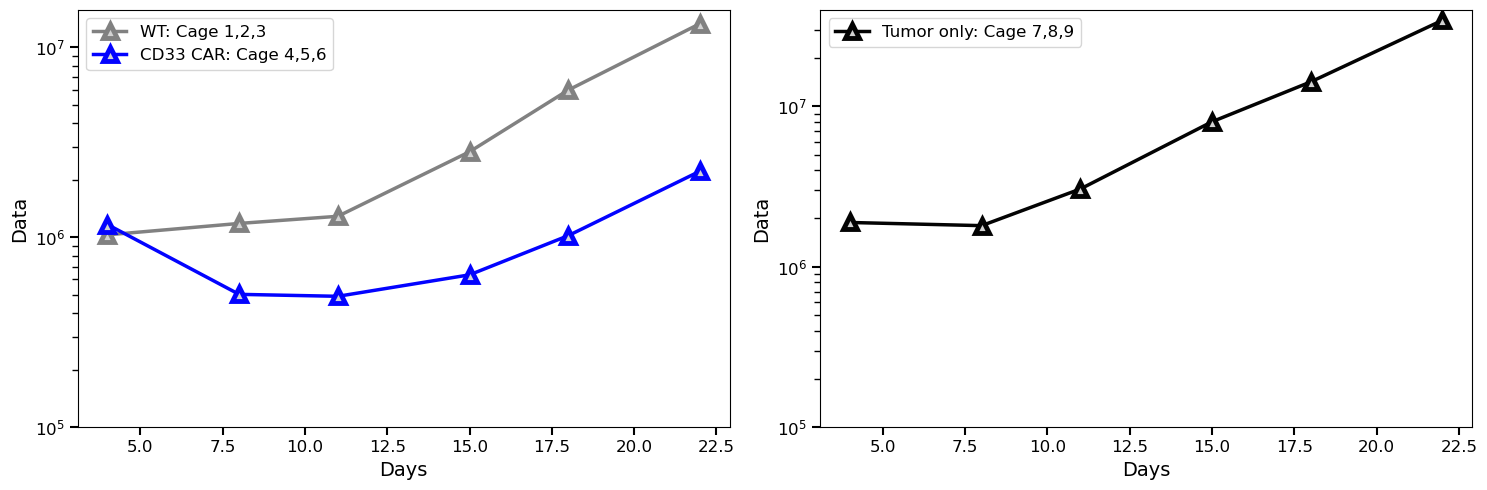

In [5]:
days,cage_mean,cage_std = mean_std_three_cages()

In [6]:
from fitting import tumor_alone_rate

In [7]:
def plot(i, days, mean_data, axes, std_data=None, color='gray',label = None):
    ax = axes
    ax.errorbar(days, mean_data,std_data,
                fmt='^-', 
                markersize=10, 
                markerfacecolor='lightgray',
                markeredgewidth=3.5, 
                markeredgecolor=color,
                linewidth=2.5, 
                color=color, 
                elinewidth=3.5, 
                capsize=8, 
                capthick=15,
                ecolor=color, 
                alpha=0.99,label=label)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12,length=6, width=1.5)
    ax.tick_params(axis='both', which='minor', labelsize=10,length=4, width=1)
    ax.set_ylabel("Data", fontsize=14) 
    ax.set_xlabel("Days", fontsize=14)
    ax.legend(fontsize=12)

### Checking perpotionality bw number of tumor cells and observed intensity

Optimal rate for tumor alone: 6.581e-03 1/day


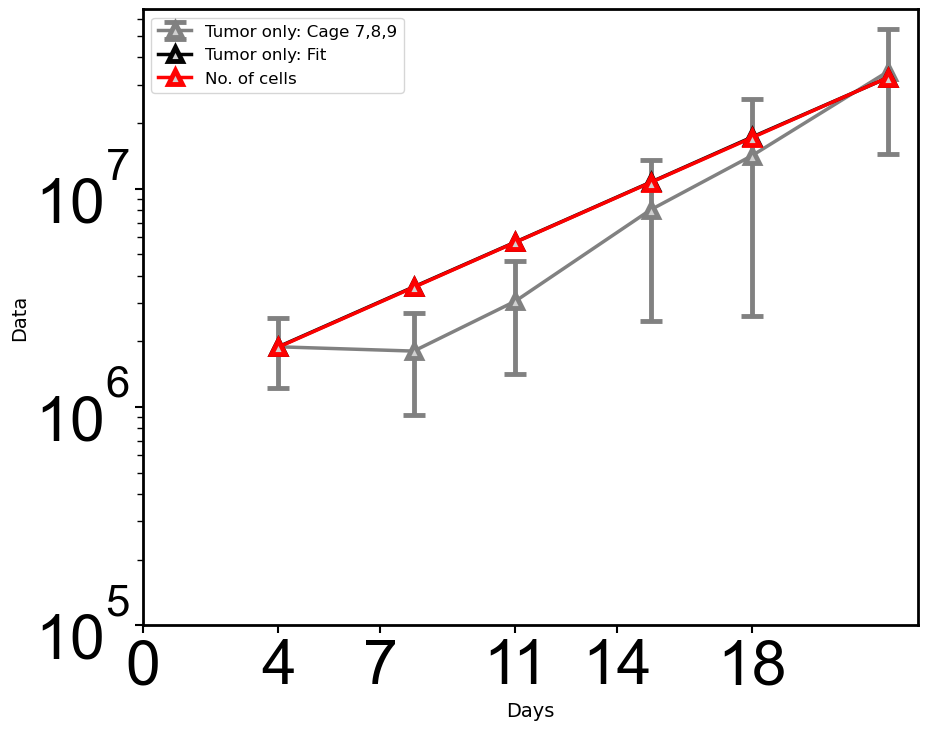

In [8]:
model_tumor_alone_data, rate = tumor_alone_rate(days,cage_mean)
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
plot(1,days+4, cage_mean[2], axs, cage_std[2],label = 'Tumor only: Cage 7,8,9')
plot(1,days+4,model_tumor_alone_data,axs,color='black',label = 'Tumor only: Fit')
plot(1,days+4,(10**6)*np.exp(rate*24*(days+4)),axs,color='red',label = 'No. of cells')
t_size = 45
plt.xticks(days,fontname="Arial",fontsize = t_size)
plt.yticks([10**5,10**6,10**7],fontname="Arial",fontsize = t_size)
#plt.savefig('tumor_alone.png')
plt.show()

(i) Assuming day 3 as starting point where both NK and tumor cells are there

(ii) Since NK flow observation are made starting from day four 

(iii) tD_all includes all times shifted by three that is like first NK dose is starting point 


In [9]:
NK_dose_time = np.array([3,7,10,14])-3   
tD_all = np.sort(np.concatenate((days+1,NK_dose_time))) # All observation time that includes NK doses and tumor observations
T_obs_idx = np.array([1,3,5,7,8,9]) # Tumor observations at days 1,3,5,7,8,9 in shifted time 
T_obs_time = np.array([tD_all[i] for i in T_obs_idx]) # in shifted time

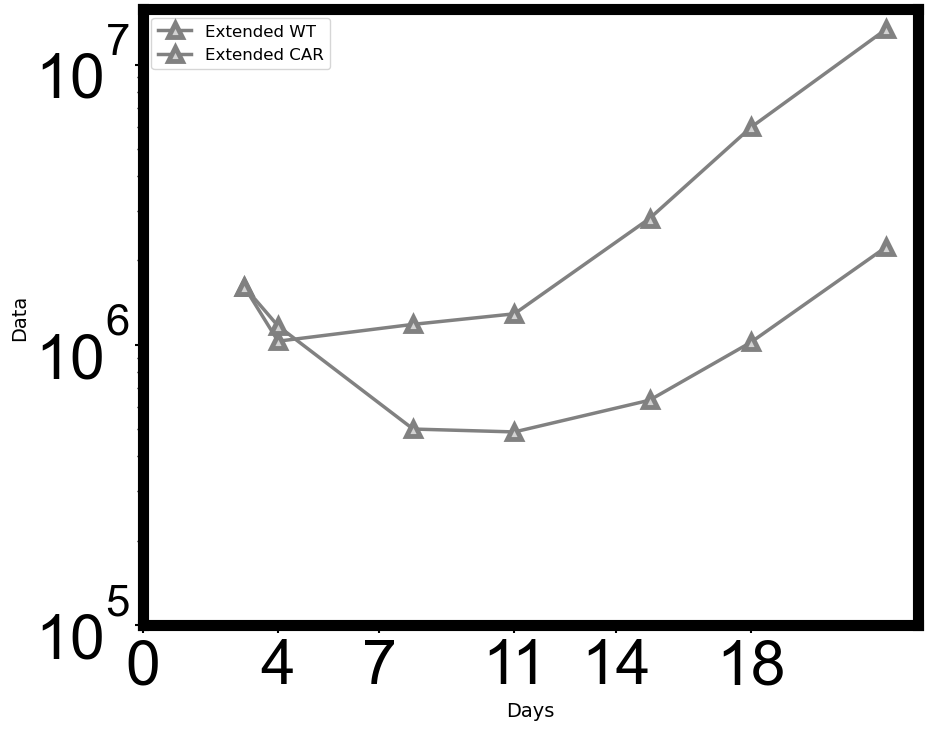

In [10]:
"""
(i) Finding the number of cells at day 3 using back calculation from tumor alone data the rate 
obtined from fitting of tumor alone data.
(ii) Its like what was number of cells at day 3 if we had not done any treatment.
"""
nubr_tumor_day_3 = cage_mean[-1][0]*np.exp(-24*rate) # finding Number of cells at day 3 using back calculation

Tumor_lysis_WT = np.append(nubr_tumor_day_3, cage_mean[0])
Tumor_lysis_CAR = np.append(nubr_tumor_day_3, cage_mean[1])
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
plot(1,np.append(3,days+4), Tumor_lysis_WT, axs, label = 'Extended WT')
plot(1,np.append(3,days+4), Tumor_lysis_CAR, axs, label = 'Extended CAR')
t_size = 45
plt.xticks(days,fontname="Arial",fontsize = t_size)
plt.yticks([10**5,10**6,10**7],fontname="Arial",fontsize = t_size)
plt.show()

In [11]:
nubr_tumor_day_3

1612322.449657173

In [12]:
from fitting import Model_fit
from Model_Wt_NK import Model_obj_WT_NK as obj_WT_NK
from Model_CAR_NK import Model_obj_CAR_NK as obj_CAR_NK

In [13]:
Sys_WT_NK = obj_WT_NK()
Sys_CAR_NK = obj_CAR_NK()

In [14]:
LB = np.array([100,1.0e-1,1.0e-1,50,
               1.0e-2,
               1.0e-2,1.0e-2,
               1.e-6,1.e-5])
UB = np.array([20.0e+3,1.0,1,2000,
               1.0e+0,
               1.0e+0,1.0e+0,
               1.e-4,1.e-1])

In [16]:
def main_WT():
    MFI_limt = [[(0, 100), (0, 250), (0.0, 50.0)], [(10, 150), (1, 70), (0.0, 50.0)]]
    Sys_CAR_NK.Cell_type_R_L(NK_cell='CAR-NK H', Tumor_cell='MV411',limts=MFI_limt)
    MFI_limt = [[(0, 10), (50, 300), (0.0, 30.0)], [(10, 150), (1, 70), (0.0, 50.0)]]
    Sys_WT_NK.Cell_type_R_L(NK_cell='WT H', Tumor_cell='MV411',limts=MFI_limt)
    x0 = [3272.0, 0.38, 0.993, 1545.0, 0.03374, 0.9604, 0.01507, 3.056e-06, 0.09993]
    res0 = Model_fit(x0,LB, UB, Sys_CAR_NK, Sys_WT_NK,tD_all*24,NK_dose_time*24,T_obs_idx,rate, data = (Tumor_lysis_WT,Tumor_lysis_CAR,cage_std),fit=False,chi2 = False,only_wt = True)
    return res0
res0 = main_WT()

Both WT NK and CAR NK data are used for fitting.
----- Optimized Parameters (2 sig. digits) -----
[3272.0, 0.38, 0.993, 1545.0, 0.03374, 0.9604, 0.01507, 3.056e-06, 0.09993]
Cost = 7.27e+12
final cost: 7.275e+12


[ 4  8 11 15 18 22]


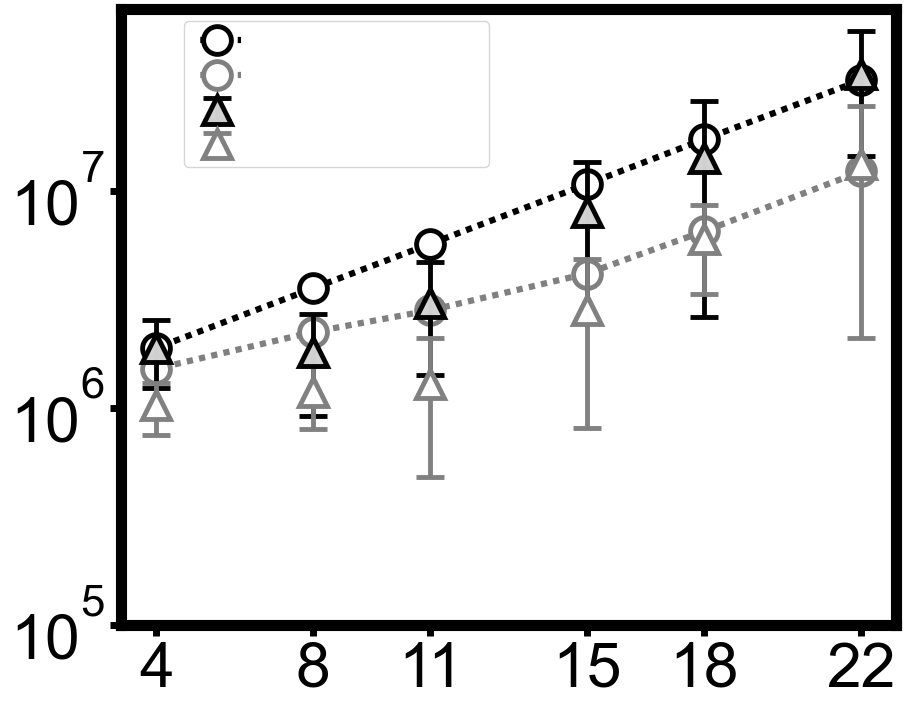

In [20]:
plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
print(days+4)
plt.plot(days+4, model_tumor_alone_data, marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='black',color = 'black',lw=lw,ls = ls[0],label = 'Tumor only')
plt.plot(T_obs_time+3, res0[0], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',color = 'gray',lw=lw,ls = ls[0],label="Fit-WT")
plt.errorbar(days+4, cage_mean[2], yerr = cage_std[2], 
             fmt='^', markersize=m_size, markerfacecolor='lightgray', markeredgewidth=3.5, markeredgecolor='black',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='black',alpha=0.99,label="Model_fit_Tumor al")
plt.errorbar(T_obs_time+3, cage_mean[0], yerr = cage_std[0], 
             fmt='^', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='gray',alpha=0.99,label="Model_fit_WT")
t_size = 45
plt.yscale('log')
plt.xticks(days+4,fontname="Arial",fontsize = t_size)
plt.yticks([10**5,10**6,10**7],fontname="Arial",fontsize = t_size)
#plt.tight_layout(pad=2.5)
#plt.xlim(0,23)
plt.legend(bbox_to_anchor=(0.49, 1),fontsize=17, loc='upper right', labelcolor='white')
plt.savefig('plt_WT_fit.png')
plt.show()

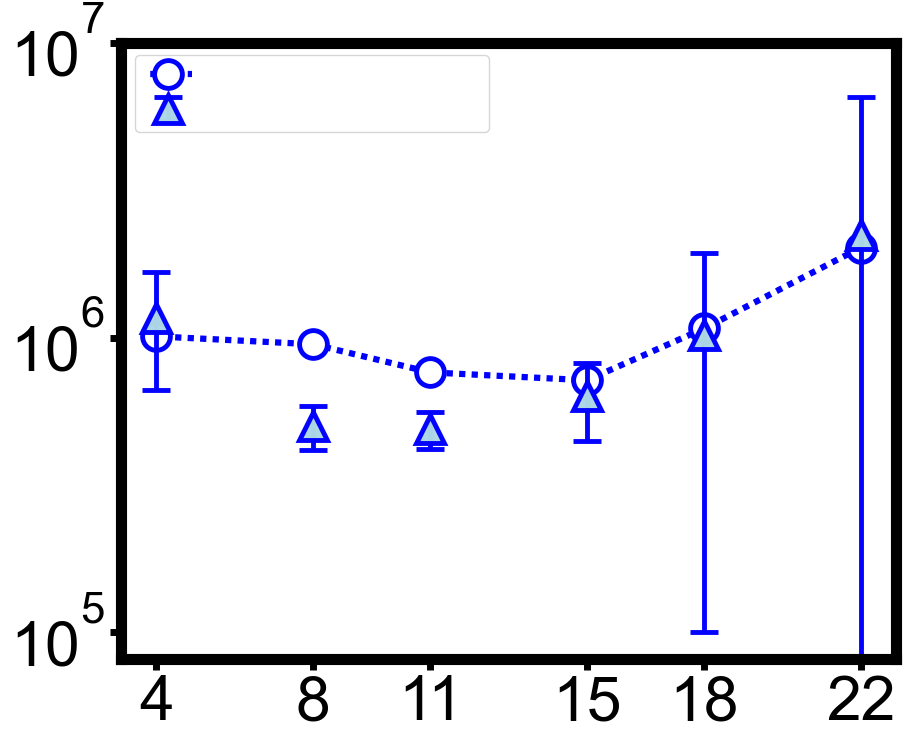

In [22]:
plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
plt.plot(T_obs_time+3, res0[1], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='blue',color = 'blue',lw=lw,ls = ls[0],label="Pred-CAR")

plt.errorbar(T_obs_time+3, cage_mean[1], yerr = cage_std[1], 
             fmt='^', markersize=m_size, markerfacecolor='lightblue', markeredgewidth=3.5, markeredgecolor='blue',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='blue',alpha=0.99,label="Model_Pred_CD33-CAR")
t_size = 45
plt.yscale('log')
plt.xticks(days+4,fontname="Arial",fontsize = t_size)
plt.yticks([10**5,10**6,10**7],fontname="Arial",fontsize = t_size)
#plt.tight_layout(pad=2.5)
plt.legend(bbox_to_anchor=(0.49, 1),fontsize=17, loc='upper right', labelcolor='white')
plt.savefig('plt_Pred_CAR.png')
plt.show()

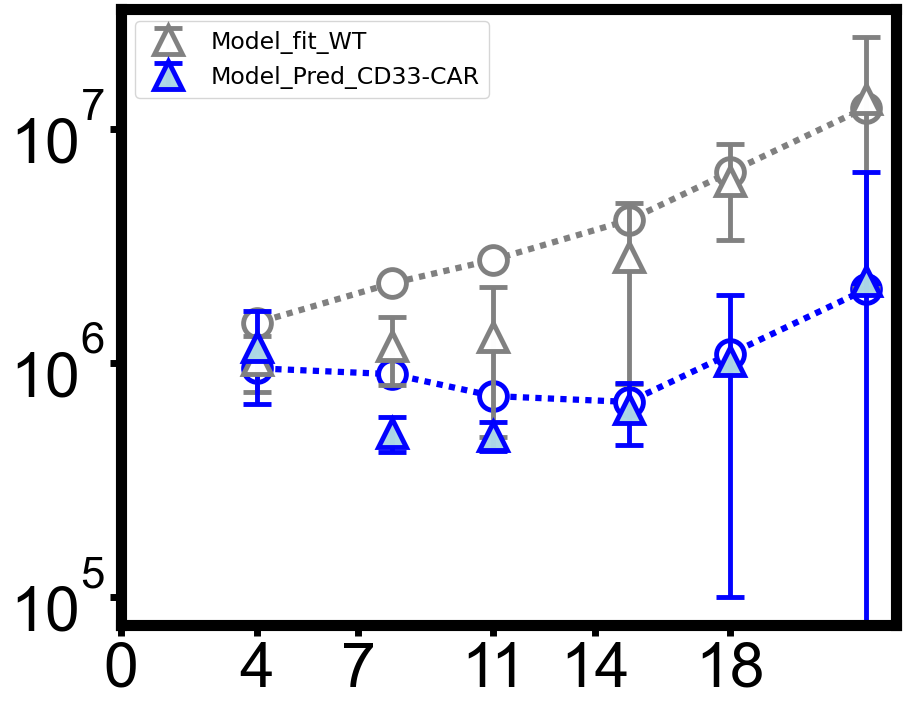

In [42]:

plt.figure(figsize=(10,8))
plt.rcParams['axes.linewidth'] = 8
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=19, length=8, width=5)
ls = [(1,(1,1)),(5, (10, 3)), (0,(2,2)), (0, (3, 1, 1, 1))]
m_size = 20
lw = 4.5
plt.plot(T_obs_time+3, res0[0], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',color = 'gray',lw=lw,ls = ls[0])#,label="Fit-WT")
plt.plot(T_obs_time+3, res0[1], marker='o', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='blue',color = 'blue',lw=lw,ls = ls[0])#,label="Pred-CAR")
plt.errorbar(T_obs_time+3, cage_mean[0], yerr = cage_std[0], 
             fmt='^', markersize=m_size, markerfacecolor='white', markeredgewidth=3.5, markeredgecolor='gray',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='gray',alpha=0.99,label="Model_fit_WT")
plt.errorbar(T_obs_time+3, cage_mean[1], yerr = cage_std[1], 
             fmt='^', markersize=m_size, markerfacecolor='lightblue', markeredgewidth=3.5, markeredgecolor='blue',
             elinewidth=3.5, capsize=10, capthick=20,
             ecolor='blue',alpha=0.99,label="Model_Pred_CD33-CAR")
t_size = 45
plt.yscale('log')
plt.xticks(days,fontname="Arial",fontsize = t_size)
plt.yticks([10**5,10**6,10**7],fontname="Arial",fontsize = t_size)
#plt.tight_layout(pad=2.5)
plt.legend(bbox_to_anchor=(0.49, 1),fontsize=17, loc='upper right', labelcolor='black')
plt.savefig('plt_WT_fit.png')
plt.show()

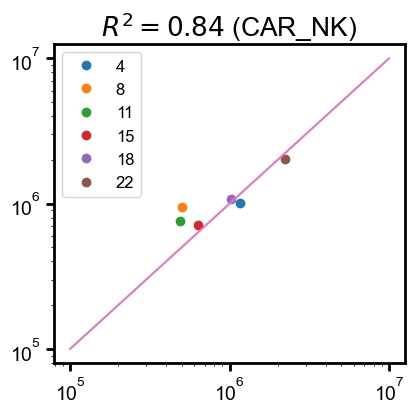

In [20]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 35
plt.rcParams['font.family'] = 'Arial'
fig, ax1 = plt.subplots(1,1,figsize = (5,5))

for i in range(len(res0[0])):
    ax1.plot(cage_mean[1][i], res0[1][i], 'o', label=f'{days[i]+4}')

ax1.plot(np.arange(100000,10000000),np.arange(100000,10000000))
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlabel('Data')
#ax1.set_ylabel('Prediction',fontsize =23)
#ax1.set_xticks([10,50,90])
#ax1.set_yticks([10,50,90])
ax1.set_title(f'$R^2 = {r2_score(cage_mean[1], res0[1]):.2f}$ (CAR_NK)',fontsize =19)
ax1.tick_params(axis='both', which='major', labelsize=14, length=6,width=2)
ax1.legend(prop = {'size':12})
plt.tight_layout()
#plt.savefig('R2_CAN_NK_Pred.png')
plt.show()

# Cost fun fitting

In [45]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
rmse_val = rmse(cage_mean[1], res0[1])
mape_val = mape(cage_mean[1], res0[1])

print("RMSE:", rmse_val)
print("MAPE:", mape_val, "%")

RMSE: 221736.9307916764
MAPE: 27.82889974905844 %
